# Задача N тел

Иоганн Кеплер (1571–1630). Несмотря на отсутсвие знаний о теории поля и динамике,
установил важные закономерности, в т.ч. *закон Кеплера*
о заметаемых движущейся вокруг центроида материальной точкой секторах.

При этом, по некоторым неподтверждённым данным, полагал, что сила тяжести от расстояния зависит как $\frac{1}{R}$, а не $\frac{1}{R^2}$.

## В нашей вселенной

У нас три пространственных измерения, одно временное и ещё с десяток (а то и больше) всяких мудрёных, которые участвуют в нашей жизни слишком неочевидным образом, чтобы относиться к данному курсу.

Материальная точка $a$ (вот об этом Кеплер не знал) индуцирует графитационное поле, которое является *потенциальным скалярным полем*. *Градиент* этого поля, умноженный на массу материальной точки $b$ индуцирует приложенную к ней силу тяжести. Сила тяжести направлена в сторону точки $a$, а её абсолютная величина пропорциональна *плотности потока* индуцированного точкой $a$ поля. Поток через любую поверхность вокруг токи $а$ постоянный. А плотность, если поверхность сферическая, обратно пропорциональна площади этой поверхности, т.е. пропорциональна $\frac{1}{R^2}$.

Смоделируем траекторию материальной точки около другой, «неподвижной» материальной точки. Находиться они будут всегда в одной плоскости, движение также будет в этой плоскости, поэтому модель вполне подойдёт двумерная, хотя мир и трёхмерный. Для двумерной модели можно бы было воспользоваться комплексными числами, но правильнее всё-таки векторами.

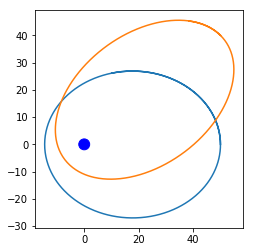

In [1]:
%matplotlib inline

import numpy
import numpy.linalg
import matplotlib.pyplot as plt

G = 50.0  # гравитационная постоянная
collision_distance = 3.0  # всё-таки это не точки
model_delta_t = 0.01
time_to_model = 10

class MaterialPoint:
    """Материальная точка, движущаяся по двумерной плоскости"""
    
    def __init__(self, mass: 'float', position: 'numpy.array', velocity: 'numpy.array'):
        # Аннотации типов по желанию, но могут помочь IDE и компилятору, когда таковые имеются
        self.mass = mass
        self.position = position
        self.velocity = velocity
    
    @staticmethod
    def gravity_dencity(dist: 'float')-> 'float':
        if dist > collision_distance:
            return G / dist ** 2
        else:
            return -G / dist ** 3 # будем считать, что отскакивают точки друг от друга резко, но стараться не допускать этого
    
    def force_induced_by_other(self, other: 'MaterialPoint')-> 'numpy.array':
        delta_p = other.position - self.position
        distance = numpy.linalg.norm(delta_p)  # Евклидова норма (по теореме Пифагора)
        force_direction = delta_p / distance
        # @staticmethod позволяет вызвать статический метод от self, не зная точного типа
        force = force_direction * self.mass * other.mass * self.gravity_dencity(distance)
        return force
    
    def advance(self):
        # print(self.position)
        self.position += self.velocity * model_delta_t

    def apply_force(self, force: 'numpy.array'):
        # print(force)
        self.velocity += force * model_delta_t / self.mass


centrum = MaterialPoint(500.0, numpy.array([0.0, 0.0]), numpy.array([0.0, 0.0]))
point_1 = MaterialPoint(10.0, numpy.array([50.0, 0.0]), numpy.array([0.0, 15.0]))
point_2 = MaterialPoint(10.0, numpy.array([50.0, 40.0]), numpy.array([-7.0, 7.0]))


def model_step():
    point_1.apply_force(point_1.force_induced_by_other(centrum))
    point_2.apply_force(point_2.force_induced_by_other(centrum))

    point_1.advance()
    point_2.advance()

    

xs_1 = []
ys_1 = []
xs_2 = []
ys_2 = []
for stepn in range(int(time_to_model / model_delta_t)):
    xs_1.append(point_1.position[0])
    ys_1.append(point_1.position[1])
    xs_2.append(point_2.position[0])
    ys_2.append(point_2.position[1])
    model_step()

c = plt.Circle((0, 0), 2, color='b')
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_aspect('equal')
ax.add_patch(c)


plt.plot(xs_1,ys_1)
plt.plot(xs_2,ys_2)

plt.show()


Мы получили идеализированную картину — материальные точки друг на друга не влияют, центроид не движется, но притягивает их, пространство трёхмерное.

## В планиверсуме

А.К. Дьюдни. Планиверсум. Виртуальный контакт с двумерным миром (оригинал англ., 1984 г.)

Вполне возможно, что сам Дьюдни, как и Кеплер (но по иным причинам) не думал о применении аппарата теории поля к описываемому им миру. А ведь в его мире материальную точку должна окружать не сфера, а окружность. И (вспоминаем Кеплера!), если теорию поля брать за основу, сила тяжести в двумерном мире действительно будет пропорциональна $\frac{1}{R}$!

### Задание

#### a

Взять код выше и смоделировать ситуацию для двумерного мира (в котором сила тяготения пропорциональна $\frac{1}{R}$) и набора из произвольного количества тел (проверить для трёх, но использовать список). При этом уменьшить количество массивов для хранения точек графиков (использовать `массив.copy()`, чтобы не терять значения).

#### b

Посмотреть, как изменится картина, когда тела начнут притягивать друг друга.